# Training of model of p-value prediction and analysis of the importance and effect of the features analyzed

## Introduction

On the "p_value_distribution_exploratory_analysis.ipynb" notebook, we observed apparent clear differences between subsets of p-values depending on several factors (affiliation country, field, species/kingdom, citation count). We also observed that the p-value dataset showed several modes of p-value roundings (0.00001, 0.001, 0.01 and 0.05) and that the most relevant ones were the 0.01 and 0.05 roundings.

Now, we want to combine the effect of each of these factors in a single prediction model of high (-Inf,0.01] and low (0.01-0.05] p-values. Thanks to this model, we will be able to evaluate if the factors analyzed can meaningfully help improve the prediction of low and high p-values achieved by the citation count. If true, this would mean that these factors are actually relevant in the distribution of p-values and their information should be taken into account when evaluating the possible quality of the study. Next, the importance of each variable in the prediction is evaluated with state-of-the-art machine learning interpretability methods. Lastly, the effect of each feature in the model is analyzed to evaluate how it influences the prediction in order to exploit its predictive potential.

In [1]:
setwd("C:\\Users\\dani5\\Documents\\Projects\\PhD\\p_value_dist\\data")

In [2]:
library(readr)
library(tidypvals)
library(caret)
library(MLmetrics)
library(dplyr)
library(xgboost)
library(DALEX)
library(pROC)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice

Welcome to DALEX (version: 0.2.4).

Attaching package: 'DALEX'

The following object is masked from 'package:dplyr':

    explain

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



## Loading of information

We create a p-values dataset with the information of the year, the article ID and the dataset where it was taken from. The dataset is in numeric form to encode as effectively as ppossible the information (1=only in 'head2015' dataset, 2=only in 'chavalarias2016' dataset, 1.5= in both datasets).

In [3]:
aj1 = anti_join(head2015,chavalarias2016)%>%mutate(dataset=1)
aj2 = anti_join(chavalarias2016,head2015)%>%mutate(dataset=2)
sj1 = semi_join(head2015,chavalarias2016)%>%mutate(dataset=1.5)
allp = rbind(aj1,aj2,sj1) %>% select(c(pvalue,year,doi,pmid,dataset))

Joining, by = c("pvalue", "year", "journal", "field", "abstract", "operator", "doi", "pmid")
Joining, by = c("pvalue", "year", "journal", "field", "abstract", "operator", "doi", "pmid")
Joining, by = c("pvalue", "year", "journal", "field", "abstract", "operator", "doi", "pmid")


Now we load the information achieved from the Pubmed and Scopus websites.

By country:

In [10]:
country_proteomics=rbind(
    read_csv("germany_proteomics.csv")%>%mutate(Country="Germany"),
    read_csv("china_proteomics.csv")%>%mutate(Country="China"),
    read_csv("us_proteomics.csv")%>%mutate(Country="US"),
    read_csv("spain_proteomics.csv")%>%mutate(Country="Spain"),
    read_csv("uk_proteomics.csv")%>%mutate(Country="UK"),
    read_csv("france_proteomics.csv")%>%mutate(Country="France"),
    read_csv("italy_proteomics.csv")%>%mutate(Country="Italy"),
    read_csv("japan_proteomics.csv")%>%mutate(Country="Japan"),
    read_csv("netherlands_proteomics.csv")%>%mutate(Country="Netherlands"),
    read_csv("canada_proteomics.csv")%>%mutate(Country="Canada")
) %>% select(EntrezUID,Country) %>%
mutate(Field="Proteomics")

country_genomics=rbind(
    read_csv("germany_genomics.csv")%>%mutate(Country="Germany"),
    read_csv("china_genomics.csv")%>%mutate(Country="China"),
    read_csv("us_genomics.csv")%>%mutate(Country="US"),
    read_csv("spain_genomics.csv")%>%mutate(Country="Spain"),
    read_csv("uk_genomics.csv")%>%mutate(Country="UK"),
    read_csv("france_genomics.csv")%>%mutate(Country="France"),
    read_csv("italy_genomics.csv")%>%mutate(Country="Italy"),
    read_csv("japan_genomics.csv")%>%mutate(Country="Japan"),
    read_csv("netherlands_genomics.csv")%>%mutate(Country="Netherlands"),
    read_csv("canada_genomics.csv")%>%mutate(Country="Canada")
) %>% select(EntrezUID,Country) %>% 
mutate(Field="Genomics")

country_transcriptomics=rbind(
    read_csv("germany_transcriptomics.csv")%>%mutate(Country="Germany"),
    read_csv("china_transcriptomics.csv")%>%mutate(Country="China"),
    read_csv("us_transcriptomics.csv")%>%mutate(Country="US"),
    read_csv("spain_transcriptomics.csv")%>%mutate(Country="Spain"),
    read_csv("uk_transcriptomics.csv")%>%mutate(Country="UK"),
    read_csv("france_transcriptomics.csv")%>%mutate(Country="France"),
    read_csv("italy_transcriptomics.csv")%>%mutate(Country="Italy"),
    read_csv("japan_transcriptomics.csv")%>%mutate(Country="Japan"),
    read_csv("netherlands_transcriptomics.csv")%>%mutate(Country="Netherlands"),
    read_csv("canada_transcriptomics.csv")%>%mutate(Country="Canada")
) %>% select(EntrezUID,Country) %>% 
mutate(Field="Transcriptomics")

metabolomics_scopus_data=read_csv('metabolomics_scopus_data.csv')

country_metabolomics=rbind(
    metabolomics_scopus_data[grep('Germany',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Germany"),
    metabolomics_scopus_data[grep('China',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="China"),
    metabolomics_scopus_data[grep('United States',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="US"),
    metabolomics_scopus_data[grep('Spain',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Spain"),
    metabolomics_scopus_data[grep('United Kingdom',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="UK"),
    metabolomics_scopus_data[grep('France',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="France"),
    metabolomics_scopus_data[grep('Italy',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Italy"),
    metabolomics_scopus_data[grep('Japan',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Japan"),
    metabolomics_scopus_data[grep('Netherlands',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Netherlands"),
    metabolomics_scopus_data[grep('Canada',metabolomics_scopus_data$Affiliations),]%>%mutate(Country="Canada")
) %>% select(PubMed.ID,Country) %>% rename(EntrezUID=PubMed.ID) %>%
mutate(Field="Metabolomics",EntrezUID=as.character(EntrezUID))

country = country_proteomics %>% 
full_join(.,country_genomics) %>%
full_join(.,country_transcriptomics) %>%
full_join(.,country_metabolomics) %>% 
distinct() %>% 
mutate(Field=as.factor(Field),Country=as.factor(Country),pmid=as.integer(EntrezUID))

Parsed with column specification:
cols(
  Title = col_character(),
  URL = col_character(),
  Description = col_character(),
  Details = col_character(),
  ShortDetails = col_character(),
  Resource = col_character(),
  Type = col_character(),
  Identifiers = col_character(),
  Db = col_character(),
  EntrezUID = col_character(),
  Properties = col_character()
)
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"6154 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                     expected   <int> <chr> <chr>      <chr>      <chr>                    actual 1     1 <NA>  11 columns 12 columns 'germany_proteomics.csv' file 2     2 <NA>  11 columns 12 columns 'germany_proteomics.csv' row 3     3 <NA>  11 columns 12 columns 'germany_proteomics.csv' col 4     4 <NA>  11 columns 12 columns 'germany_proteomics.csv' expected 5     5 <NA>  11 columns 12 columns 'german

"Parsed with column specification:
cols(
  Title = col_character(),
  URL = col_character(),
  Description = col_character(),
  Details = col_character(),
  ShortDetails = col_character(),
  Resource = col_character(),
  Type = col_character(),
  Identifiers = col_character(),
  Db = col_character(),
  EntrezUID = col_character(),
  Properties = col_character()
)
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"2837 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                   expected   <int> <chr> <chr>      <chr>      <chr>                  actual 1     1 <NA>  11 columns 12 columns 'italy_proteomics.csv' file 2     2 <NA>  11 columns 12 columns 'italy_proteomics.csv' row 3     3 <NA>  11 columns 12 columns 'italy_proteomics.csv' col 4     4 <NA>  11 columns 12 columns 'italy_proteomics.csv' expected 5     5 <NA>  11 columns 12 columns 'italy_proteomics.

"Parsed with column specification:
cols(
  Title = col_character(),
  URL = col_character(),
  Description = col_character(),
  Details = col_character(),
  ShortDetails = col_character(),
  Resource = col_character(),
  Type = col_character(),
  Identifiers = col_character(),
  Db = col_character(),
  EntrezUID = col_character(),
  Properties = col_character()
)
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"5611 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file              expected   <int> <chr> <chr>      <chr>      <chr>             actual 1     1 <NA>  11 columns 12 columns 'us_genomics.csv' file 2     2 <NA>  11 columns 12 columns 'us_genomics.csv' row 3     3 <NA>  11 columns 12 columns 'us_genomics.csv' col 4     4 <NA>  11 columns 12 columns 'us_genomics.csv' expected 5     5 <NA>  11 columns 12 columns 'us_genomics.csv'
... ................. ... ....

"Parsed with column specification:
cols(
  Title = col_character(),
  URL = col_character(),
  Description = col_character(),
  Details = col_character(),
  ShortDetails = col_character(),
  Resource = col_character(),
  Type = col_character(),
  Identifiers = col_character(),
  Db = col_character(),
  EntrezUID = col_character(),
  Properties = col_character()
)
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"5991 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                       expected   <int> <chr> <chr>      <chr>      <chr>                      actual 1     1 <NA>  11 columns 12 columns 'netherlands_genomics.csv' file 2     2 <NA>  11 columns 12 columns 'netherlands_genomics.csv' row 3     3 <NA>  11 columns 12 columns 'netherlands_genomics.csv' col 4     4 <NA>  11 columns 12 columns 'netherlands_genomics.csv' expected 5     5 <NA>  11 columns 12 co

Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"1370 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                        expected   <int> <chr> <chr>      <chr>      <chr>                       actual 1     1 <NA>  11 columns 12 columns 'spain_transcriptomics.csv' file 2     2 <NA>  11 columns 12 columns 'spain_transcriptomics.csv' row 3     3 <NA>  11 columns 12 columns 'spain_transcriptomics.csv' col 4     4 <NA>  11 columns 12 columns 'spain_transcriptomics.csv' expected 5     5 <NA>  11 columns 12 columns 'spain_transcriptomics.csv'
... ................. ... ............................................................... ........ ............................................................... ...... ............................................................... .... ............................................................... ... ...................

"Parsed with column specification:
cols(
  Title = col_character(),
  URL = col_character(),
  Description = col_character(),
  Details = col_character(),
  ShortDetails = col_character(),
  Resource = col_character(),
  Type = col_character(),
  Identifiers = col_character(),
  Db = col_character(),
  EntrezUID = col_character(),
  Properties = col_character()
)
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"1935 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                         expected   <int> <chr> <chr>      <chr>      <chr>                        actual 1     1 <NA>  11 columns 12 columns 'canada_transcriptomics.csv' file 2     2 <NA>  11 columns 12 columns 'canada_transcriptomics.csv' row 3     3 <NA>  11 columns 12 columns 'canada_transcriptomics.csv' col 4     4 <NA>  11 columns 12 columns 'canada_transcriptomics.csv' expected 5     5 <NA>  11 c

By species/kingdom:

In [11]:
species_proteomics=rbind(
    read_csv("human_proteomics.csv")%>%mutate(Species="Human"),
    read_csv("animal_proteomics.csv")%>%mutate(Species="Animal"),
    read_csv("plant_proteomics.csv")%>%mutate(Species="Plant"),
    read_csv("bacteria_proteomics.csv")%>%mutate(Species="Bacteria")
) %>% select(EntrezUID,Species) %>% mutate(Field="Proteomics")

species_genomics=rbind(
    read_csv("human_genomics.csv")%>%mutate(Species="Human"),
    read_csv("animal_genomics.csv")%>%mutate(Species="Animal"),
    read_csv("plant_genomics.csv")%>%mutate(Species="Plant"),
    read_csv("bacteria_genomics.csv")%>%mutate(Species="Bacteria")
) %>% select(EntrezUID,Species) %>% mutate(Field="Genomics")

species_transcriptomics=rbind(
    read_csv("human_transcriptomics.csv")%>%mutate(Species="Human"),
    read_csv("animal_transcriptomics.csv")%>%mutate(Species="Animal"),
    read_csv("plant_transcriptomics.csv")%>%mutate(Species="Plant"),
    read_csv("bacteria_transcriptomics.csv")%>%mutate(Species="Bacteria")
) %>% select(EntrezUID,Species) %>% mutate(Field="Transcriptomics")

metabolomics_scopus_data=read_csv('metabolomics_scopus_data.csv')

species_metabolomics=rbind(
    metabolomics_scopus_data[grep('human',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Human"),
    metabolomics_scopus_data[grep('animal',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Animal"),
    metabolomics_scopus_data[grep('plant',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Plant"),
    metabolomics_scopus_data[grep('bacteria',metabolomics_scopus_data$Abstract),]%>%mutate(Species="Bacteria")
) %>% select(PubMed.ID,Species) %>% rename(EntrezUID=PubMed.ID) %>%
mutate(Field="Metabolomics",EntrezUID=as.character(EntrezUID))

species = species_proteomics %>% 
full_join(.,species_genomics) %>%
full_join(.,species_transcriptomics) %>%
full_join(.,species_metabolomics)  %>% 
distinct() %>% 
mutate(Field=as.factor(Field),Species=as.factor(Species),pmid=as.integer(EntrezUID))


Parsed with column specification:
cols(
  Title = col_character(),
  URL = col_character(),
  Description = col_character(),
  Details = col_character(),
  ShortDetails = col_character(),
  Resource = col_character(),
  Type = col_character(),
  Identifiers = col_character(),
  Db = col_character(),
  EntrezUID = col_character(),
  Properties = col_character()
)
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"38699 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                   expected   <int> <chr> <chr>      <chr>      <chr>                  actual 1     1 <NA>  11 columns 12 columns 'human_proteomics.csv' file 2     2 <NA>  11 columns 12 columns 'human_proteomics.csv' row 3     3 <NA>  11 columns 12 columns 'human_proteomics.csv' col 4     4 <NA>  11 columns 12 columns 'human_proteomics.csv' expected 5     5 <NA>  11 columns 12 columns 'human_proteomics.

"Parsed with column specification:
cols(
  Title = col_character(),
  URL = col_character(),
  Description = col_character(),
  Details = col_character(),
  ShortDetails = col_character(),
  Resource = col_character(),
  Type = col_character(),
  Identifiers = col_character(),
  Db = col_character(),
  EntrezUID = col_character(),
  Properties = col_character()
)
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"22825 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                 expected   <int> <chr> <chr>      <chr>      <chr>                actual 1     1 <NA>  11 columns 12 columns 'plant_genomics.csv' file 2     2 <NA>  11 columns 12 columns 'plant_genomics.csv' row 3     3 <NA>  11 columns 12 columns 'plant_genomics.csv' col 4     4 <NA>  11 columns 12 columns 'plant_genomics.csv' expected 5     5 <NA>  11 columns 12 columns 'plant_genomics.csv'
... ....

"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"7114 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual     file                           expected   <int> <chr> <chr>      <chr>      <chr>                          actual 1     1 <NA>  11 columns 12 columns 'bacteria_transcriptomics.csv' file 2     2 <NA>  11 columns 12 columns 'bacteria_transcriptomics.csv' row 3     3 <NA>  11 columns 12 columns 'bacteria_transcriptomics.csv' col 4     4 <NA>  11 columns 12 columns 'bacteria_transcriptomics.csv' expected 5     5 <NA>  11 columns 12 columns 'bacteria_transcriptomics.csv'
... ................. ... .................................................................. ........ .................................................................. ...... .................................................................. .... .................................................................. ... ...................................

By citation:

In [12]:
proteomics_citation_data = merge(
    rbind(
        read_csv("proteomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("proteomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("proteomics_scopus_1.csv"),
        read_csv("proteomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% mutate(Citation=as.numeric(Citation),Field="Proteomics")

genomics_citation_data = merge(
    rbind(
        read_csv("genomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("genomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("genomics_scopus_1.csv"),
        read_csv("genomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% mutate(Citation=as.numeric(Citation),Field="Genomics")

transcriptomics_citation_data = merge(
    rbind(
        read_csv("transcriptomics_citation_1.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8])),
        read_csv("transcriptomics_citation_2.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        ) %>% distinct() %>% rename("Title" = "Document Title"),
    rbind(
        read_csv("transcriptomics_scopus_1.csv"),
        read_csv("transcriptomics_scopus_2.csv")
        ) %>% distinct(),
    by='Title')  %>% 
select(DOI,Citation) %>% mutate(Citation=as.numeric(Citation),Field="Transcriptomics")

metabolomics_scopus_data=read_csv('metabolomics_scopus_data.csv')

metabolomics_citation_data = merge(
        read_csv("metabolomics_citation.csv",skip=6) %>% select(c(1:7,ncol(.))) %>% rename("Citation" = !!names(.[8]))
        %>% rename("Title" = "Document Title"),
        read_csv("metabolomics_scopus.csv"),
    by='Title')  %>% 
select(DOI,Citation) %>% mutate(Citation=as.numeric(Citation),Field="Metabolomics")

citation=proteomics_citation_data %>% 
full_join(.,genomics_citation_data) %>%
full_join(.,transcriptomics_citation_data) %>%
full_join(.,metabolomics_citation_data)  %>% 
distinct() %>% 
mutate(Field=as.factor(Field),doi=as.character(DOI))

Parsed with column specification:
cols(
  `Publication Year` = col_integer(),
  `Document Title` = col_character(),
  Authors = col_character(),
  ISSN = col_character(),
  `Journal Title` = col_character(),
  Volume = col_character(),
  Issue = col_character(),
  `38` = col_integer(),
  `2` = col_integer(),
  `15` = col_integer(),
  `1079` = col_integer(),
  `14561` = col_integer(),
  `38530` = col_integer(),
  `64211` = col_integer(),
  `118398` = col_integer(),
  `214506` = col_integer(),
  `332942` = col_integer()
)
Parsed with column specification:
cols(
  `Publication Year` = col_integer(),
  `Document Title` = col_character(),
  Authors = col_character(),
  ISSN = col_character(),
  `Journal Title` = col_character(),
  Volume = col_character(),
  Issue = col_character(),
  `27483` = col_integer(),
  `44770` = col_integer(),
  `68158` = col_integer(),
  `90447` = col_integer(),
  `100508` = col_integer(),
  `95765` = col_integer(),
  `88016` = col_integer(),
  `487664` = col_inte

"Parsed with column specification:
cols(
  `Publication Year` = col_integer(),
  `Document Title` = col_character(),
  Authors = col_character(),
  ISSN = col_character(),
  `Journal Title` = col_character(),
  Volume = col_character(),
  Issue = col_character(),
  `21` = col_integer(),
  `20` = col_integer(),
  `0` = col_integer(),
  `2` = col_integer(),
  `19` = col_integer(),
  `1026` = col_integer(),
  `14195` = col_integer(),
  `44240` = col_integer(),
  `84525` = col_integer(),
  `144027` = col_integer(),
  `323361` = col_integer(),
  `467409` = col_integer()
)
Parsed with column specification:
cols(
  `Publication Year` = col_integer(),
  `Document Title` = col_character(),
  Authors = col_character(),
  ISSN = col_character(),
  `Journal Title` = col_character(),
  Volume = col_character(),
  Issue = col_character(),
  `42` = col_integer(),
  `1332` = col_integer(),
  `7373` = col_integer(),
  `16556` = col_integer(),
  `29007` = col_integer(),
  `42892` = col_integer(),
  `665

## Integration of sources of information

First, we can evaluate the different datasets to integrate with the p-value dataset.

In [13]:
summary(country)

  EntrezUID            Country                  Field            pmid         
 Length:157299      China  :37730   Genomics       :82422   Min.   : 1282491  
 Class :character   Germany:24410   Metabolomics   :14482   1st Qu.:21043482  
 Mode  :character   US     :14829   Proteomics     :34202   Median :24670775  
                    Canada :13785   Transcriptomics:26193   Mean   :23375615  
                    France :13764                           3rd Qu.:26631584  
                    Japan  :13637                           Max.   :28878260  
                    (Other):39144                           NA's   :40        

In [14]:
summary(species)

  EntrezUID             Species                   Field       
 Length:297088      Animal  :103494   Genomics       :155620  
 Class :character   Bacteria: 45017   Metabolomics   :  6027  
 Mode  :character   Human   :107044   Proteomics     : 79237  
                    Plant   : 41533   Transcriptomics: 56204  
                                                              
                                                              
                                                              
      pmid         
 Min.   : 1282491  
 1st Qu.:18674278  
 Median :23017455  
 Mean   :21840316  
 3rd Qu.:25809453  
 Max.   :28840100  
 NA's   :16        

In [15]:
summary(citation)

     DOI               Citation                    Field      
 Length:104689      Min.   :    0.00   Genomics       :33392  
 Class :character   1st Qu.:    6.00   Metabolomics   : 8574  
 Mode  :character   Median :   15.00   Proteomics     :36593  
                    Mean   :   33.19   Transcriptomics:26130  
                    3rd Qu.:   32.00                          
                    Max.   :21776.00                          
     doi           
 Length:104689     
 Class :character  
 Mode  :character  
                   
                   
                   

In [16]:
summary(allp)

     pvalue             year          doi                 pmid         
 Min.   : 0.0000   Min.   :1967   Length:3574058     Min.   : 1284032  
 1st Qu.: 0.0014   1st Qu.:2011   Class :character   1st Qu.:21193574  
 Median : 0.0230   Median :2012   Mode  :character   Median :23139356  
 Mean   : 0.0871   Mean   :2012                      Mean   :22268413  
 3rd Qu.: 0.0500   3rd Qu.:2013                      3rd Qu.:24379671  
 Max.   :10.0000   Max.   :2015                      Max.   :28140909  
                                                     NA's   :21003     
    dataset     
 Min.   :1.000  
 1st Qu.:1.500  
 Median :1.500  
 Mean   :1.625  
 3rd Qu.:2.000  
 Max.   :2.000  
                

The scientific article to study has to be present in all four datasets in order to be integrated its information in the final training dataset. It seems the citation dataset is the bottleneck as is the one with a lower sample size.

Before merging the citation, species and country datasets to the p-value dataset, we need to translate the DOI of the citation dataset into a Pubmed ID. To do this, we will take use of the information present in the allp dataset to build a translator of DOI into Pubmed ID. Then, we will perform the translation of the DOI information in the citaiton dataset.

In [17]:
pmed_doi_translator=unique(allp%>%select(doi,pmid))%>%na.omit()

citation=citation %>%
left_join(.,pmed_doi_translator,by=c("DOI"="doi")) %>% 
select(-c(doi,DOI))%>%na.omit()

In [18]:
summary(citation)

    Citation                   Field           pmid         
 Min.   :   0.00   Genomics       :3993   Min.   :16920744  
 1st Qu.:   8.00   Metabolomics   : 954   1st Qu.:21489291  
 Median :  16.00   Proteomics     :3273   Median :23226273  
 Mean   :  32.22   Transcriptomics:6331   Mean   :22748199  
 3rd Qu.:  33.00                          3rd Qu.:24392655  
 Max.   :4358.00                          Max.   :25608477  

Now, we can combine the information of the three datasets.

In [19]:
combined_info=country%>%
full_join(.,citation,by=c("Field", "pmid"))%>%
full_join(.,species,by=c("Field", "pmid"))%>%
filter(!is.na(pmid))%>%
select(-c(EntrezUID.x,EntrezUID.y))

In [20]:
summary(combined_info)

    Country                   Field             pmid             Citation     
 China  : 46102   Genomics       :189778   Min.   : 1282491   Min.   :   0.0  
 Germany: 30367   Metabolomics   : 16664   1st Qu.:19280682   1st Qu.:   8.0  
 US     : 18137   Proteomics     : 88050   Median :23521840   Median :  16.0  
 France : 17236   Transcriptomics: 62977   Mean   :22275108   Mean   :  31.8  
 Canada : 17056                            3rd Qu.:26104761   3rd Qu.:  33.0  
 (Other): 64748                            Max.   :28878260   Max.   :4358.0  
 NA's   :163823                                               NA's   :338624  
     Species      
 Animal  :107905  
 Bacteria: 47705  
 Human   :114681  
 Plant   : 44160  
 NA's    : 43018  
                  
                  

And join this information with the one of the p-value dataset:

In [21]:
allp_reduced=allp%>%
filter(pmid %in% combined_info$pmid)%>%
left_join(combined_info,by="pmid")%>%
select(pvalue,year,dataset,Country,Field,Species,Citation)

Basic information of the resulting p-value dataset:

In [22]:
summary(allp_reduced)

     pvalue              year         dataset         Country     
 Min.   : 0.00000   Min.   :2001   Min.   :1.000   US     :24132  
 1st Qu.: 0.00100   1st Qu.:2011   1st Qu.:1.500   China  :19506  
 Median : 0.02000   Median :2013   Median :2.000   Germany:12161  
 Mean   : 0.05953   Mean   :2012   Mean   :1.772   Canada : 8671  
 3rd Qu.: 0.05000   3rd Qu.:2014   3rd Qu.:2.000   France : 8525  
 Max.   : 9.99989   Max.   :2015   Max.   :2.000   (Other):28657  
                                                   NA's   :89728  
             Field           Species         Citation      
 Genomics       :96498   Animal  :58430   Min.   :   0.00  
 Metabolomics   : 9536   Bacteria:19655   1st Qu.:   8.00  
 Proteomics     :26779   Human   :62659   Median :  16.00  
 Transcriptomics:58567   Plant   :17235   Mean   :  30.66  
                         NA's    :33401   3rd Qu.:  33.00  
                                          Max.   :4358.00  
                                          NA

In [23]:
dim(allp_reduced)

[1] 191380      7

There are 191380 p-values (with associated information) in the dataset.

Now, let's evaluate how many of these rows have complete information ("TRUE") and in how many rows there is a missing value in at least one of the features ("FALSE"):

In [24]:
table(complete.cases(allp_reduced))


 FALSE   TRUE 
139551  51829 

It can be seen that most rows have missing information in one or more features. This missing information can be imputed thanks e.g. to state-of-the-art random forest based methods. However, there is a trade-off between sample size and imputation of missing values:

- The higher the sample size the better the machine learning model trained.
- The higher the proportion of imputed values in the dataset the lower the quality of the dataset and the worse the model trained.

Therefore, several exploratory studies were performed to find the best combination of sample size and need of imputation of missing values. The final treatment chosen is explained in the next section.

## Further treatment of data before training models

Now, we perform the next actions:

* Removal of non-significant p-values (although it might be interesting to analyze if there are factors which explain higher tendency not to report non-significant p-values).
* Dichotomization of significant p-values into lower than 0.01 (high p-values) and between 0.01 and 0.05 (low p-values). A thorough explanation of the convenience to perform this kind of binning is present on the "p_value_distribution_exploratory_analysis.ipynb" notebook.

In addition, to ensure the possible use of packages in later steps, the names of categories and column names are adapted to the R notation.

In [25]:
p_value_final=allp_reduced%>%
  mutate(pvalue=cut(pvalue,breaks=c(min(pvalue),0.01,0.05)))%>%
filter(!is.na(pvalue))%>%
mutate(pvalue=as.factor(make.names(pvalue)))

names(p_value_final)=make.names(names(p_value_final))

The summary of the updated p-value dataset:

In [26]:
summary(p_value_final)

          pvalue           year         dataset        Country     
 X.0.0.01.   :89937   Min.   :2001   Min.   :1.00   US     :21289  
 X.0.01.0.05.:78888   1st Qu.:2011   1st Qu.:1.50   China  :17757  
                      Median :2013   Median :2.00   Germany:10527  
                      Mean   :2012   Mean   :1.78   Canada : 7655  
                      3rd Qu.:2014   3rd Qu.:2.00   France : 7501  
                      Max.   :2015   Max.   :2.00   (Other):25180  
                                                    NA's   :78916  
             Field           Species         Citation     
 Genomics       :83401   Animal  :52056   Min.   :   0.0  
 Metabolomics   : 8502   Bacteria:17629   1st Qu.:   8.0  
 Proteomics     :24137   Human   :54798   Median :  16.0  
 Transcriptomics:52785   Plant   :15549   Mean   :  30.4  
                         NA's    :28793   3rd Qu.:  32.0  
                                          Max.   :4358.0  
                                          N

Approx. a 10% of rows have been lost as these were non-significant p-values.

The pre-processing of the missing values is the next one:

- The rows with NA in the 'Citation' feature are removed, as the imputation of missing values worsened the performance of the final prediction model.
- The NAs in the Species and Country features are imputed as a new category.

In [27]:
p_value_final=p_value_final%>%
filter(!is.na(Citation))%>%
mutate(Country=addNA(Country),Species=addNA(Species))

Summary of the updated p-value dataset:

In [28]:
summary(p_value_final)

          pvalue           year         dataset         Country     
 X.0.0.01.   :53927   Min.   :2006   Min.   :1.000   NA     :50822  
 X.0.01.0.05.:49166   1st Qu.:2011   1st Qu.:1.500   US     :14394  
                      Median :2013   Median :2.000   China  : 9464  
                      Mean   :2012   Mean   :1.778   Germany: 6244  
                      3rd Qu.:2014   3rd Qu.:2.000   France : 4359  
                      Max.   :2014   Max.   :2.000   Canada : 4134  
                                                     (Other):13676  
             Field           Species         Citation     
 Genomics       :24568   Animal  :28638   Min.   :   0.0  
 Metabolomics   : 8157   Bacteria: 9853   1st Qu.:   8.0  
 Proteomics     :20116   Human   :32970   Median :  16.0  
 Transcriptomics:50252   Plant   : 9302   Mean   :  30.4  
                         NA      :22330   3rd Qu.:  32.0  
                                          Max.   :4358.0  
                                   

We can observe the number of high p-values ('X.0.0.01.') is approx. 10% than the number of low p-values ('X.0.01.0.05.'). This class imbalance might exert an influence in the training of the prediction model. Therefore, the Cohen's Kappa metric will be chosen during model training.

## Building of model

Predictions will be done by a 10-fold cross-validation approach. We need to save the predictions generated to later interpret the model.

In [9]:
train_control <- trainControl(method = "cv",
                              number = 10,
                              classProbs=TRUE,
                              savePredictions = "final")

After some exploration of the optimal hyperparameters, we decide to set these ones as the same ones for every model created in order to ensure that results cannot be possibly explained by the variance in the hyperparameter values.

In [10]:
xgb_grid <- expand.grid(
                        nrounds = 300,
                       max_depth = 9,
                       min_child_weight = 3,
                       subsample = 0.8,
                       gamma = 0,
                       colsample_bytree = 0.8,
                       eta = 0.3)

Now it is the moment to create the general model. The metric chosen to train and evaluate the model is Cohen's Kappa. The algorithm will be gradient boosting.

In [11]:
set.seed(1);system.time(xgboost_model <- train(pvalue ~ ., 
                p_value_final, 
                method = "xgbTree",
                metric = "Kappa",
                tuneGrid = xgb_grid,
                trControl = train_control))

   user  system elapsed 
 748.07  206.33  466.21 

Which is the performance of the model generated in each one of the folds?

In [12]:
xgboost_model$resample

Accuracy,Kappa,Resample
0.6505966,0.2975326,Fold01
0.6512756,0.2997256,Fold02
0.6642739,0.3254334,Fold03
0.6620757,0.3202428,Fold04
0.6543797,0.3048436,Fold05
0.6490105,0.2938707,Fold06
0.6532493,0.3023937,Fold07
0.6507906,0.2975657,Fold08
0.6601358,0.3165623,Fold09
0.6607177,0.3177571,Fold10


Cohen's Kappa is quite stable (0.3 approx.). This is equivalent to predicting correctly approx. two of every three observations only with the information reported (i.e., without any actual need to read the article in order to evaluate its quality).

It is possible to evaluate more metrics by the 'confusionMatrix' function:

In [20]:
head(xgboost_model$pred)

nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample,pred,obs,X.0.0.01.,X.0.01.0.05.,rowIndex,Resample
300,9,0.3,0,0.8,3,0.8,X.0.01.0.05.,X.0.01.0.05.,0.0319582,0.9680418,2,Fold01
300,9,0.3,0,0.8,3,0.8,X.0.0.01.,X.0.0.01.,0.5282021,0.4717979,14,Fold01
300,9,0.3,0,0.8,3,0.8,X.0.01.0.05.,X.0.0.01.,0.4913545,0.5086455,17,Fold01
300,9,0.3,0,0.8,3,0.8,X.0.01.0.05.,X.0.01.0.05.,0.3382576,0.6617424,26,Fold01
300,9,0.3,0,0.8,3,0.8,X.0.0.01.,X.0.0.01.,0.6480796,0.3519204,32,Fold01
300,9,0.3,0,0.8,3,0.8,X.0.0.01.,X.0.0.01.,0.7622784,0.2377216,49,Fold01


In [18]:
print(confusionMatrix(xgboost_model$pred$pred,xgboost_model$pred$obs,positive = "X.0.01.0.05.",mode="everything"))

Confusion Matrix and Statistics

              Reference
Prediction     X.0.0.01. X.0.01.0.05.
  X.0.0.01.        37975        19548
  X.0.01.0.05.     15952        29618
                                          
               Accuracy : 0.6557          
                 95% CI : (0.6527, 0.6586)
    No Information Rate : 0.5231          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3076          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6024          
            Specificity : 0.7042          
         Pos Pred Value : 0.6499          
         Neg Pred Value : 0.6602          
              Precision : 0.6499          
                 Recall : 0.6024          
                     F1 : 0.6253          
             Prevalence : 0.4769          
         Detection Rate : 0.2873          
   Detection Prevalence : 0.4420          
      Balanc

The F1 score is 0.6253 (the weak p-value os the 'positive' class). However, this metric might be increased by choosing a different threshold to classify low or high p-values (at the expense of decreasing the accuracy in the p-value classification).

Let's check if the calibration curve of the model presents problems:

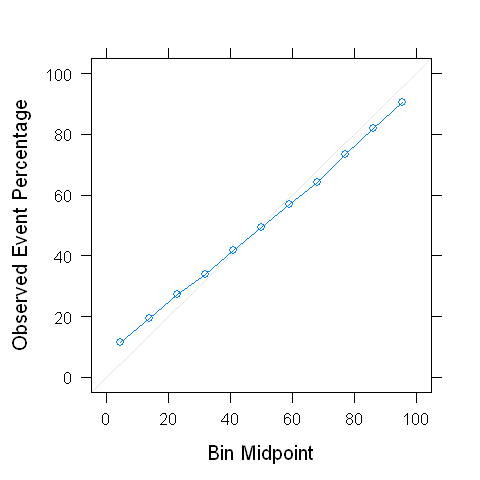

In [22]:
options(repr.plot.width=4, repr.plot.height=4)

testProbs <- data.frame(obs = xgboost_model$pred$obs, pred = xgboost_model$pred$X.0.01.0.05.)

calPlotData <- calibration(obs ~ pred, data = testProbs,class="X.0.01.0.05.")

xyplot(calPlotData, auto.key = list(columns = 2))

## Interpretability of the model

### Variable importance

To be able to interpret the model, we will use the DALEX package. First, we need to create a model explainer:

In [24]:
data=p_value_final%>%
        filter(!(seq(nrow(p_value_final)) %in% train_idx))

model_explainer <- DALEX::explain(xgboost_model, 
                                   data=data%>%select(-pvalue),
                                   y=as.vector(as.numeric(data$pvalue)))


Then we can plot the importance of each factor in the performance of the model with a dropout-based method. Thin kind of method helps evalauting how the model is worsened by the elimination of random information in the features. As this method can give some variance in the results, these results are averaged and normalized in 20 iterations. The higher the value in the feature the higher the importance of the feature in the model. If a variable shows a value similar to the one of '_full_model_', it is not relevant in the prediction.

In [25]:
dummy=variable_dropout(model_explainer)
variable_dropout_results=matrix(NA,nrow(dummy),20)
rownames(variable_dropout_results)=sort(dummy$variable)

for (i in 1:20) {
    set.seed(i);var_drop_res=variable_dropout(model_explainer)
    variable_dropout_results[,i]=(var_drop_res$dropout_loss[order(var_drop_res$variable)])/max(var_drop_res$dropout_loss)
}

In [26]:
sort(rowMeans(variable_dropout_results),decreasing=T)

_baseline_     Citation      Country         year        Field      Species 
   1.0000000    0.9116185    0.8073139    0.7879697    0.7568448    0.7247933 
     dataset _full_model_ 
   0.7140156    0.5810604

We see that the citation count information is, as expected, the most important feature in the prediction of low and high p-values: there is a reason it has been chosen as the default method to try to parameterize the quality of a study.

However, all the variables analyzed show capacity to help in the prediction of low and high p-values. Therefore, these features related to socioeconomic information or dependency paths are actually relevant in the final distribution of p-values achieved (and, presumably, in the quality of the research performed) and might be taken into account when evaluating the possible quality of the study or the need to improve the minimum requirements in order to publish studies. According to the dropout method, the most important features of these ones are the year of publication and the country of affiliation. 

A validation that each of these features is relevant in the prediction of the p-value class is performed in the 'ablation_studies.ipynb' notebook.

### Variable response

Now, it is the moment to interpret how each variable affects to the model. This is performed with the help of:

- In the case of numeric variables, Accumulated local effects (ALE) plots. In contrast to partial dependence plots (PDPs), this kind of analysis is robust to the effect of correlated covariates, then it ensures the right interpretability of the effect of each numeric feature. https://christophm.github.io/interpretable-ml-book/ale.html

- In the case of categorical variables, with the Addaptive Post-Hoc Fusing of Groups. https://mi2datalab.github.io/factorMerger/

In the kinds of plots generated, there is a direct relationship between the prediction of low p-values and the y-axis. For example, it is expected that a higher citation count in the x-axis means a lower value in the y-axis, as we know from the exploratory analysis that a higher citation count means a lower proportion of low p-values.

#### Citation count:

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


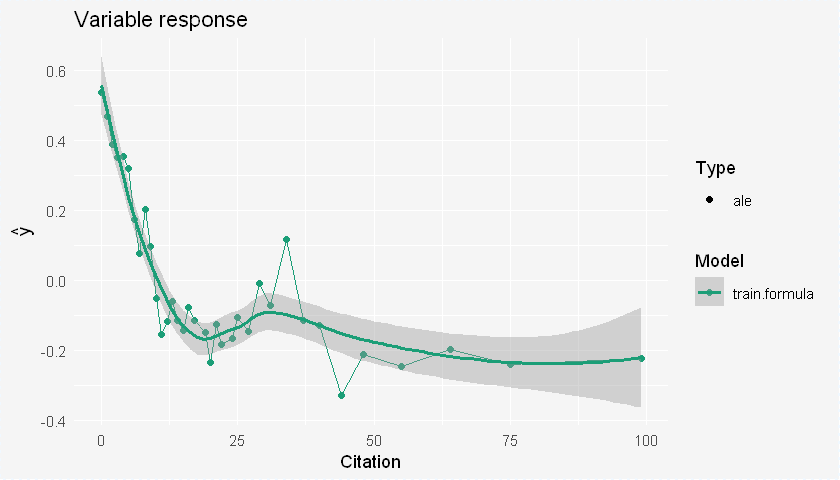

In [34]:
options(repr.plot.width=7, repr.plot.height=4)
pdp_citation_data=data[data$Citation<100,]
dummy <- DALEX::explain(xgboost_model, 
                                   data=pdp_citation_data%>%
                                     select(-pvalue),
                                   y=as.vector(as.numeric(pdp_citation_data$pvalue)))
plot(variable_response(dummy, variable =  "Citation", type = "ale"))+geom_smooth()

According to this analysis, there is a clear relationship between the citation count and the output of low p-values until arriving to approx. 20 citations. When having approx. more than 20 citations, this effect saturates: a higher number of citations is not clearly associated with a lower proportion of low p-values (and, possibly, to a higher quality of research).

#### Year of publication:

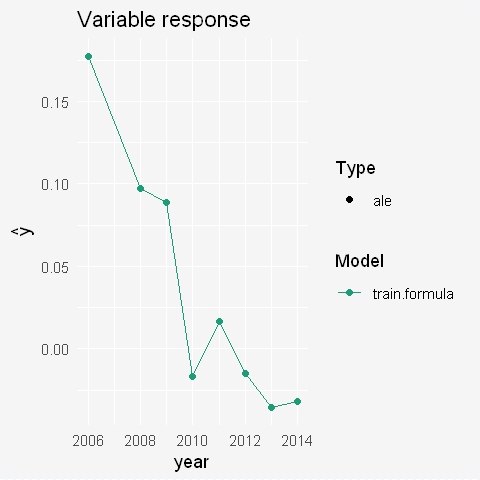

In [28]:
plot(variable_response(model_explainer, variable =  "year", type = "ale"))


A more recency of the publication is related to a lower generation of low p-values. As explained during the exploratory analysis, the inverse trend found in the exploratory analysis is possibly related to confounders such as the dataset the p-value was extracted from.

#### Country of affiliation:

Variable Country  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


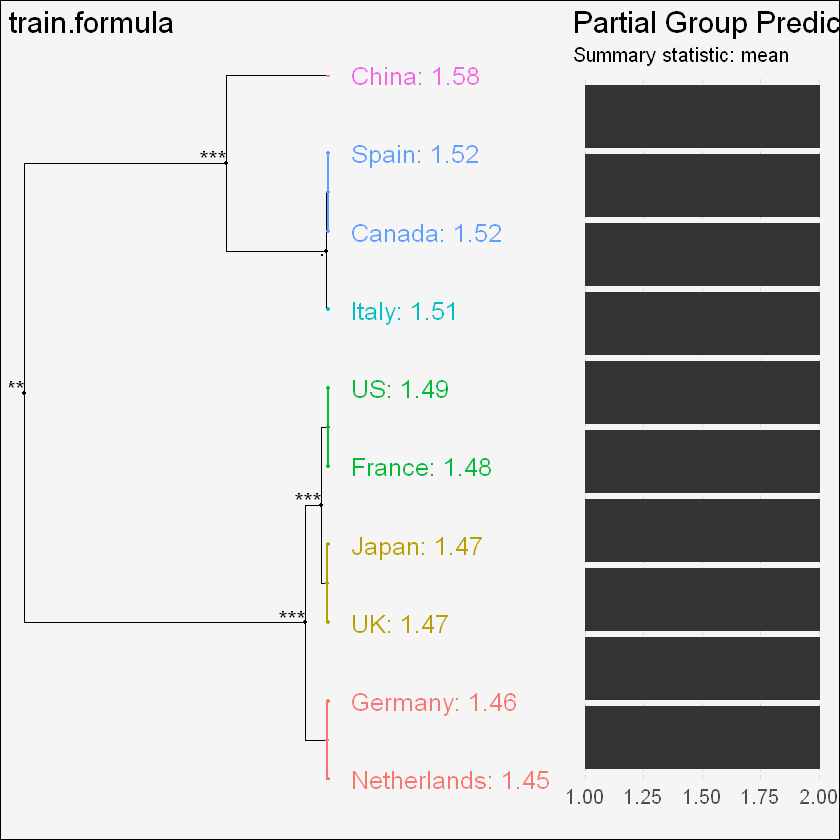

In [29]:
options(repr.plot.width=7, repr.plot.height=7)

plot(variable_response(model_explainer, variable =  "Country"))


As inferrred during the exploratory analysis, the articles with China as country of affiliation are the most associated ones with a higher generation of low p-values. This effect is possibly related to the current output of studies of lower impact (caused by the recent emergence of scientific research in this country) which cannot be fully parameterized by the citation count. 

On the other hand, Germany and the Netherlands show the lowest proportion of low p-values in their studies. The high generation of low p-values in Spain in the exploratory analysis becomes less important in this analysis: possibly this high generation of low p-values was related to a research of lower impact which is well parameterized by the citation count.

#### -Omics field:

Variable Field  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


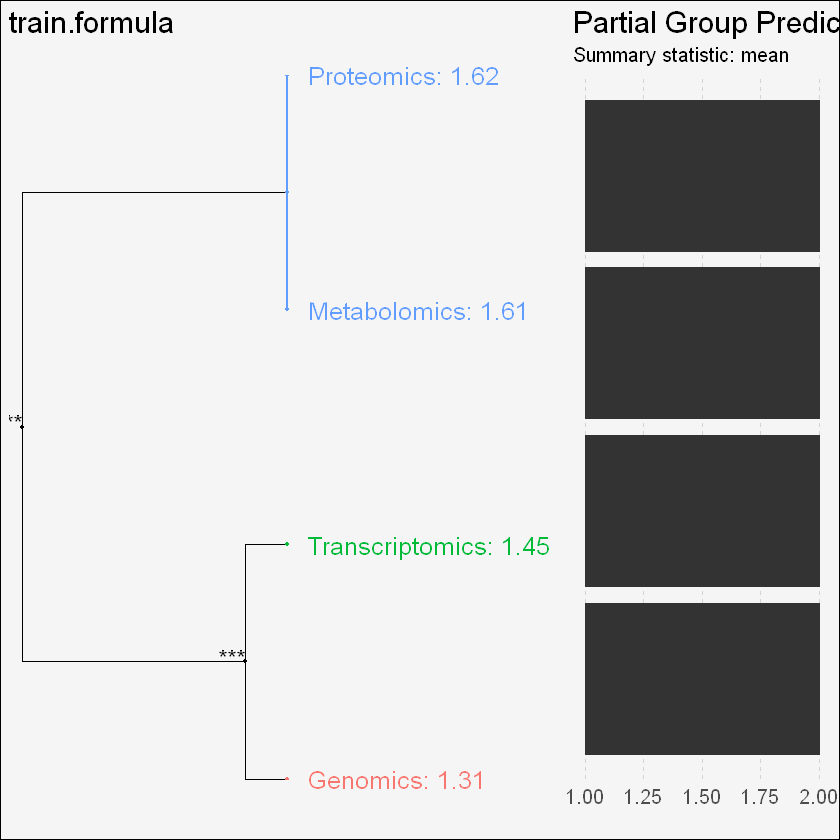

In [30]:
plot(variable_response(model_explainer, variable =  "Field", type = "ale"))


The results found here are coherent with the conclusions achieved during the exploratory analysis. These reuslts suggest it might be necessary to improve the minimum conditions to publish a study in fields where the phenotype exerts more influence (proteomics, metabolomics) as therem ight be an excessive generation of low p-values related to irreproducible results.

#### Species/kingdom analyzed:

Variable Species  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


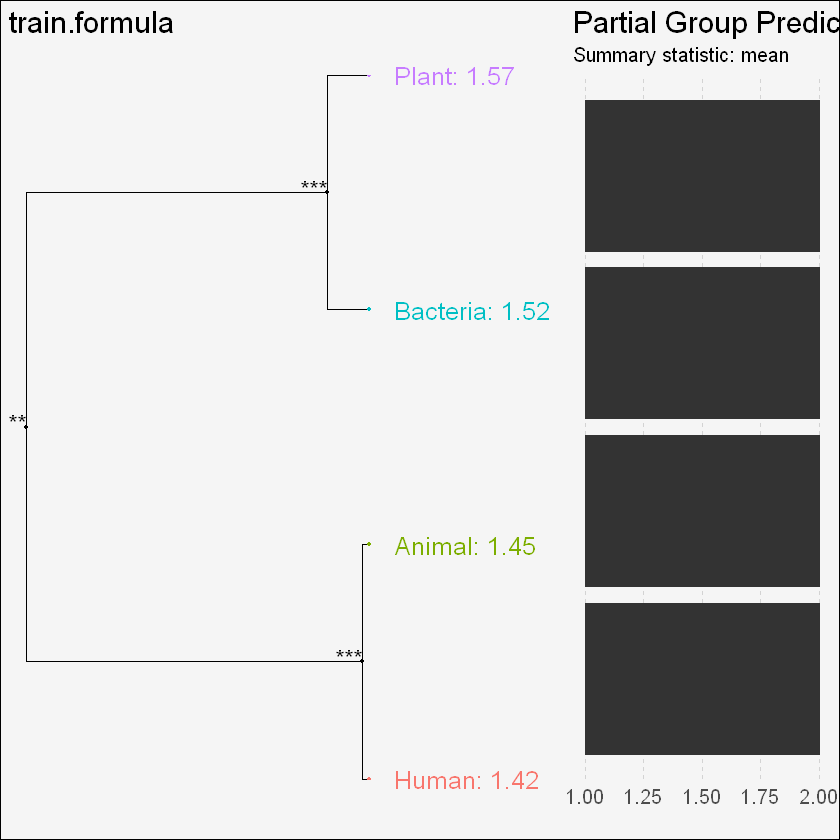

In [31]:
plot(variable_response(model_explainer, variable =  "Species", type = "ale"))


The results found here are coherent with the conclusions acchieved during the exploratory analysis. These results suggest it might be necessary to improve the minimum conditions to publish a study when studying bacteria or plants as the current output of low p-values might be excessive.

#### p-value dataset source:

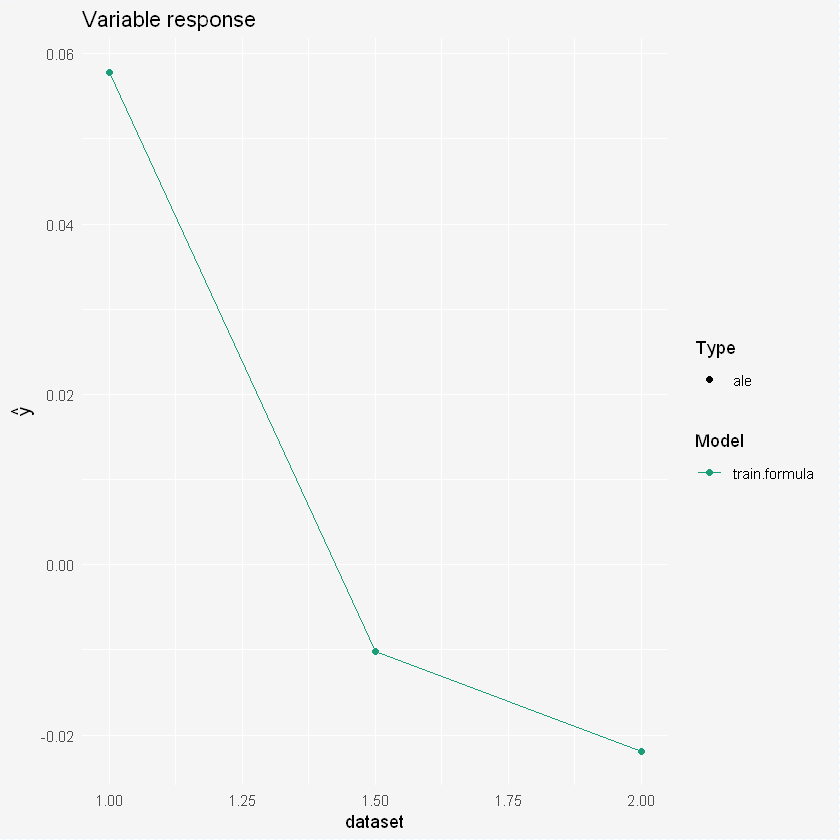

In [32]:
plot(variable_response(model_explainer, variable =  "dataset", type = "ale"))


As expected, the 'chavalarias2016' dataset (dataset==2) has a higher proportion of low p-values. Therefore, this confounder needs to be monitored in any study which uses the same repository of p-values like the one used in this study.

In [33]:
save.image("notebook_06_01_2019.RData")